In [1]:
!pip install numpy
!pip install pandas
!pip install scikit-learn

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 200)

In [6]:
file_path = '/Users/vatsalsivaratri/Documents/[01] School/[01] High School/[04] Senior Year/[06] Machine Learning/weka datasets/credit_card_scores/train.csv'
data = pd.read_csv(file_path)

In [7]:
for column in data:
    print(f"{column}: {data[column].isna().sum()}")

ID: 0
Customer_ID: 0
Month: 0
Name: 9985
Age: 0
SSN: 0
Occupation: 0
Annual_Income: 0
Monthly_Inhand_Salary: 15002
Num_Bank_Accounts: 0
Num_Credit_Card: 0
Interest_Rate: 0
Num_of_Loan: 0
Type_of_Loan: 11408
Delay_from_due_date: 0
Num_of_Delayed_Payment: 7002
Changed_Credit_Limit: 0
Num_Credit_Inquiries: 1965
Credit_Mix: 0
Outstanding_Debt: 0
Credit_Utilization_Ratio: 0
Credit_History_Age: 9030
Payment_of_Min_Amount: 0
Total_EMI_per_month: 0
Amount_invested_monthly: 4479
Payment_Behaviour: 0
Monthly_Balance: 1200
Credit_Score: 0


In [8]:
useless_columns = ['ID', 'Customer_ID', 'Name', 'SSN']
data.drop(useless_columns, axis=1, inplace=True)

In [9]:
def remove_trailing_underscore(data, column_name):
    def clean_value(value):
        if isinstance(value, str) and value.endswith('_'):
            return value[:-1]
        return value
    
    data[column_name] = data[column_name].apply(clean_value)
    
    return data

for column in data.columns:
    data = remove_trailing_underscore(data, column)

KeyboardInterrupt: 

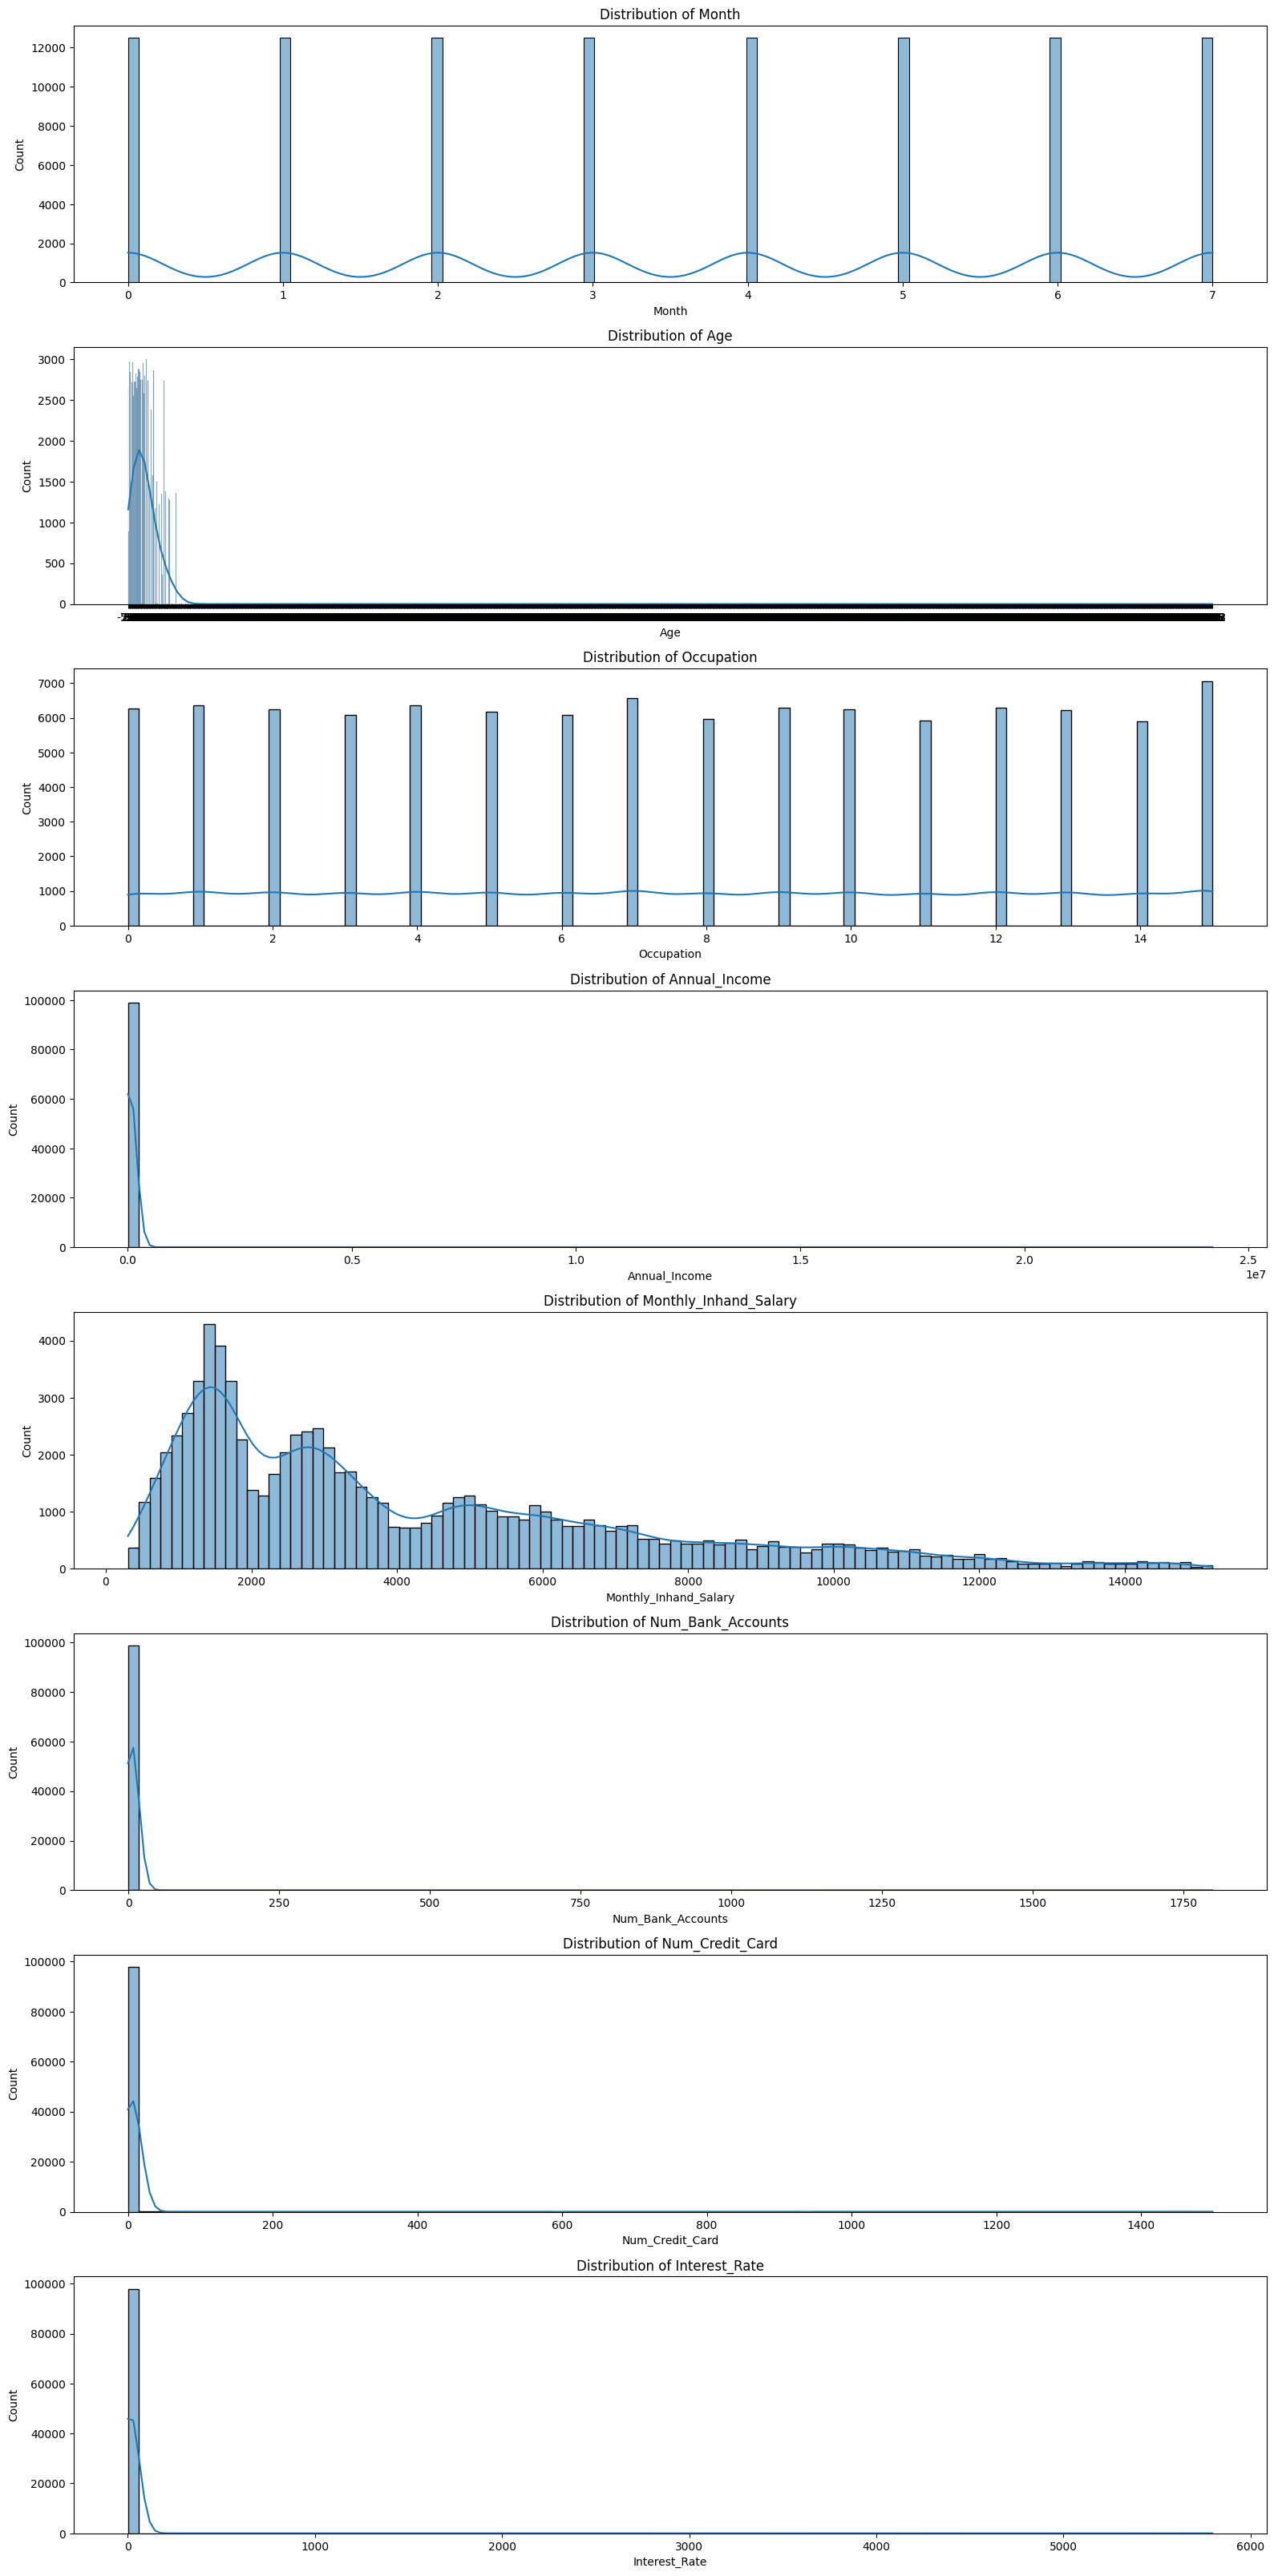

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(data, plot_type='hist'):
    num_columns = len(data.columns)
    
    plt.figure(figsize=(16, num_columns * 4))
    
    for i, column in enumerate(data.columns, 1):
        plt.subplot(num_columns, 1, i)
        
        if plot_type == 'hist':
            sns.histplot(data[column], kde=True, bins=100)
            plt.title(f'Distribution of {column}')
        elif plot_type == 'box':
            sns.boxplot(x=data[column])
            plt.title(f'Boxplot of {column}')
        
        plt.tight_layout()

    plt.show()

plot_feature_distributions(data, plot_type='hist')

In [75]:
def process_age(data):
    age = pd.to_numeric(data['Age'], errors='coerce')

    wrong_ages = age[(age == -500) | (age>995) | (age<18)].index

    data = data.drop(wrong_ages)

    data['Age'] = pd.to_numeric(data['Age'], errors='coerce')

    return data
data = process_age(data)

def process_ir(data):
    ir = pd.to_numeric(data['Interest_Rate'], errors='coerce')

    wrong_irs = ir[(ir <0) | (ir>100)].index

    data = data.drop(wrong_irs)

    data['Interest_Rate'] = pd.to_numeric(data['Interest_Rate'], errors='coerce')

    return data
data = process_ir(data)

def convert_credit_history_age_to_months(data):
    def convert_to_months(value):
        if pd.isna(value):
            return None
        parts = value.split('and')
        years = int(parts[0].strip().split()[0])
        months = int(parts[1].strip().split()[0])
        return years * 12 + months


    data['Credit_History_Age'] = data['Credit_History_Age'].apply(convert_to_months)

    data['Credit_History_Age'].fillna(data['Credit_History_Age'].mean(), inplace=True)

    return data
data = convert_credit_history_age_to_months(data)


def add_loan_type_columns(data):
    unique_loan_types = ['Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan',
                     'No Loan', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan']

    for loan_type in unique_loan_types:

        cleaned_loan_type = loan_type.replace(' ', '_').replace('-', '_').lower()

        data[cleaned_loan_type] = data['Type_of_Loan'].apply(lambda x: x.count(loan_type) if isinstance(x, str) else 0)
    data.drop(['Type_of_Loan'], axis=1, inplace=True)
    return data

data = add_loan_type_columns(data)


def process_delayed_payment(data):
    delayed_payment = pd.to_numeric(data['Num_of_Delayed_Payment'], errors='coerce')

    wrong_irs = delayed_payment[((delayed_payment < 0))].index

    data = data.drop(wrong_irs)

    data['Num_of_Delayed_Payment'] = pd.to_numeric(data['Num_of_Delayed_Payment'], errors='coerce')

    return data
data = process_delayed_payment(data)


def process_amount_invested_monthly(data):
    
    data['Amount_invested_monthly'] = data['Amount_invested_monthly'].replace('__10000_', pd.NA)
    
    data['Amount_invested_monthly'] = pd.to_numeric(data['Amount_invested_monthly'], errors='coerce')

    return data

data = process_amount_invested_monthly(data)


def process_payment_behavior(data):
    
    data['Payment_Behaviour'] = data['Payment_Behaviour'].replace('!@9#%8', '0')

    return data
data = process_payment_behavior(data)

In [76]:
mean_columns = ['Monthly_Inhand_Salary', 'Amount_invested_monthly', 'Monthly_Balance', 'Changed_Credit_Limit']
mode_columns = ['Num_of_Delayed_Payment', 'Num_Credit_Inquiries']
categorical_mode = ['Payment_Behaviour']

for column in mean_columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')
    
    data[column].fillna(data[column].mean(), inplace=True)
for column in mode_columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')
    
    data[column].fillna(data[column].mode()[0], inplace=True)


In [77]:
# from sklearn.preprocessing import LabelEncoder

# toEncode = ['Month', 'Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']

# label_encoders = {}

# for column in toEncode:
#     label_encoder = LabelEncoder()
#     data[column] = label_encoder.fit_transform(data[column]) 
    
#     label_encoders[column] = label_encoder
    
#     print(f"\nOriginal values and their encoded values for column '{column}':")
#     for original_value, encoded_value in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
#         print(f"{original_value} -> {encoded_value}")



# Good = 0
# Poor = 1
# Standard = 2


Original values and their encoded values for column 'Month':
April -> 0
August -> 1
February -> 2
January -> 3
July -> 4
June -> 5
March -> 6
May -> 7

Original values and their encoded values for column 'Occupation':
Accountant -> 0
Architect -> 1
Developer -> 2
Doctor -> 3
Engineer -> 4
Entrepreneur -> 5
Journalist -> 6
Lawyer -> 7
Manager -> 8
Mechanic -> 9
Media_Manager -> 10
Musician -> 11
Scientist -> 12
Teacher -> 13
Writer -> 14
______ -> 15

Original values and their encoded values for column 'Credit_Mix':
 -> 0
Bad -> 1
Good -> 2
Standard -> 3

Original values and their encoded values for column 'Payment_of_Min_Amount':
NM -> 0
No -> 1
Yes -> 2

Original values and their encoded values for column 'Payment_Behaviour':
0 -> 0
High_spent_Large_value_payments -> 1
High_spent_Medium_value_payments -> 2
High_spent_Small_value_payments -> 3
Low_spent_Large_value_payments -> 4
Low_spent_Medium_value_payments -> 5
Low_spent_Small_value_payments -> 6

Original values and their encoded

In [56]:
toNumeric = ['Annual_Income', 'Num_of_Loan', 'Changed_Credit_Limit', 'Outstanding_Debt']
for column in toNumeric:
    data[column] = pd.to_numeric(data[column], errors='coerce')

toEncode = ['Month', 'Occupation','Credit_Mix','Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']
label_encoder = LabelEncoder()
for column in toEncode:
    data[column] = label_encoder.fit_transform(data[column])
for column in categorical_mode:
    data[column].fillna(data[column].mode()[0], inplace=True)

In [13]:
def replace_negatives_with_mode_or_mean(data, mode_list, mean_list):
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
        if column in mode_list:
            mode_value = data[column].mode()[0]
            data[column] = data[column].apply(lambda x: mode_value if x < 0 else x)
    
        elif column in mean_list:
            mean_value = data[column].mean()
            data[column] = data[column].apply(lambda x: mean_value if x < 0 else x)
    return data
    
mean_columns = ['Monthly_Inhand_Salary', 'Amount_invested_monthly', 'Monthly_Balance', 
                'Changed_Credit_Limit', 'Annual_Income', 'Interest_Rate', 'Changed_Credit_Limit',
                'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month']
mode_columns = list(set(data.columns)-set(mean_columns)-{'Credit_Score'})

data = replace_negatives_with_mode_or_mean(data, mean_columns, mode_columns)

In [14]:
for column in data.columns:
    data[column] = pd.to_numeric(data[column], errors='coerce') 
    
    data[column].fillna(data[column].mean(), inplace=True)
    
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    data = data[~((data[column] < (Q1 - 3 * IQR)) | (data[column] > (Q3 + 3 * IQR)))]

In [15]:
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

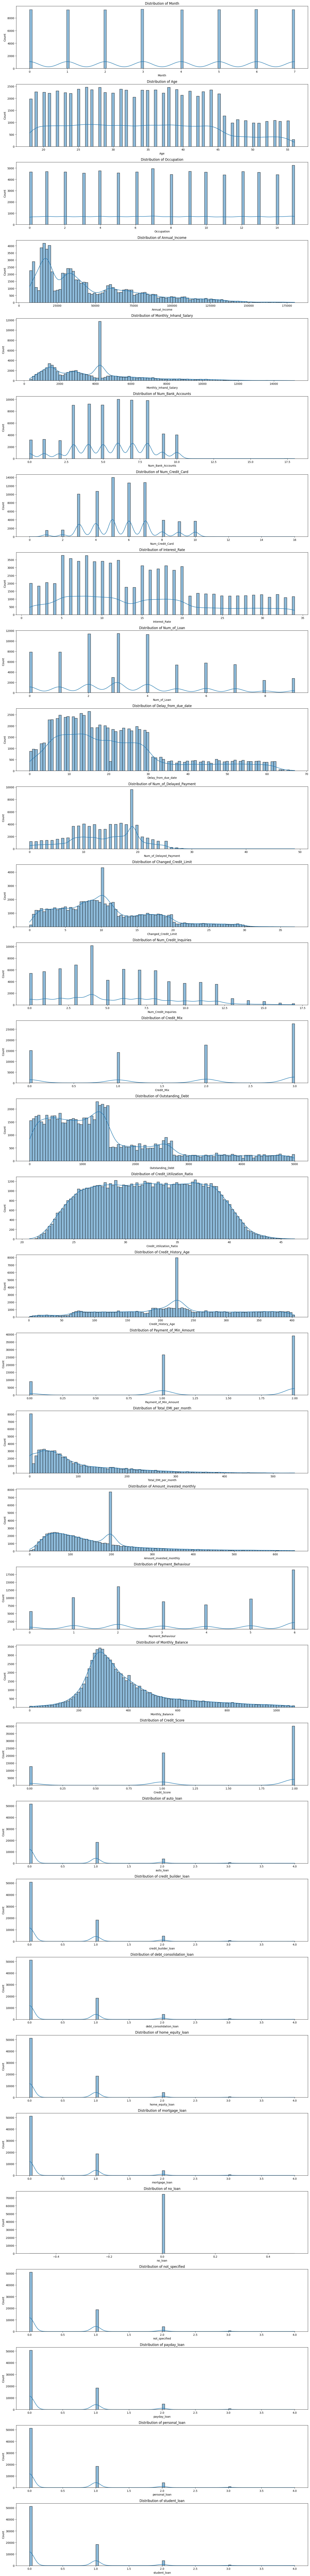

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(df, plot_type='hist'):
    num_columns = len(df.columns)
    
    plt.figure(figsize=(16, num_columns * 4))
    
    for i, column in enumerate(df.columns, 1):
        plt.subplot(num_columns, 1, i)
        
        if plot_type == 'hist':
            sns.histplot(df[column], kde=True, bins=100)
            plt.title(f'Distribution of {column}')
        elif plot_type == 'box':
            sns.boxplot(x=df[column])
            plt.title(f'Boxplot of {column}')
        
        plt.tight_layout()

    plt.show()

plot_feature_distributions(data, plot_type='hist')


In [44]:
data.head(50)['Credit_Score']

0         Good
1         Good
2         Good
3         Good
4         Good
5         Good
6         Good
7     Standard
8     Standard
9         Good
10    Standard
11        Good
12        Good
13        Good
14        Good
15        Good
16        Good
17        Good
18        Good
19        Good
20        Good
21        Good
22    Standard
23    Standard
24    Standard
25    Standard
26    Standard
27    Standard
28    Standard
29    Standard
30    Standard
31    Standard
32    Standard
33    Standard
34    Standard
35    Standard
36    Standard
37    Standard
38    Standard
39    Standard
40        Good
41        Good
42        Good
43        Good
44        Good
45        Good
46    Standard
47        Good
48        Good
49        Good
Name: Credit_Score, dtype: object

In [37]:
data[data['Credit_Score']=='Poor']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
56,0x1656,CUS_0x5407,January,Annk,7580,500-92-6408,Media_Manager,34081.38_,NaN,8,7,15,3,"Not Specified, Auto Loan, and Student Loan",30,11,17.13,5.000,Standard,1704.18,24.448,NaN,NM,70.478,162.4410091967751,Low_spent_Large_value_payments,298.19215813115227,Poor
57,0x1657,CUS_0x5407,February,Annk,30,500-92-6408,Media_Manager,34081.38,2611.115,8,7,15,3,"Not Specified, Auto Loan, and Student Loan",30,14,17.13,5.000,_,1704.18,35.171,14 Years and 8 Months,Yes,70.478,38.4369827577036,High_spent_Large_value_payments,392.19618457022375,Poor
58,0x1658,CUS_0x5407,March,Annk,30_,500-92-6408,Media_Manager,34081.38,NaN,8,7,15,3,"Not Specified, Auto Loan, and Student Loan",31,14,17.13,5.000,Standard,1704.18,35.112,14 Years and 9 Months,Yes,70.478,199.7207654954979,Low_spent_Large_value_payments,260.9124018324295,Poor
59,0x1659,CUS_0x5407,April,Annk,30,500-92-6408,_______,34081.38,2611.115,8,7,15,3,"Not Specified, Auto Loan, and Student Loan",34,14,21.13,5.000,_,1704.18,29.762,14 Years and 10 Months,Yes,70.478,220.55219192916718,Low_spent_Small_value_payments,260.0809753987602,Poor
63,0x165d,CUS_0x5407,August,Annk,30,500-92-6408,Media_Manager,34081.38,2611.115,8,7,15,3,"Not Specified, Auto Loan, and Student Loan",30,14,17.13,9.000,_,1704.18,33.823,15 Years and 2 Months,Yes,70.478,29.32636371091455,High_spent_Medium_value_payments,411.3068036170128,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0x25fe8,CUS_0x942c,March,Nicks,25,078-73-5990,Mechanic,39628.99,3359.416,4,6,7,2,"Auto Loan, and Student Loan",20,6,9.5,3.000,_,502.38,39.324,31 Years and 5 Months,No,35.104,140.58140274528395,High_spent_Medium_value_payments,410.256,Poor
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.416,4,6,7,2,"Auto Loan, and Student Loan",23,7,11.5,3.000,_,502.38,34.664,31 Years and 6 Months,No,35.104,60.97133255718485,High_spent_Large_value_payments,479.866,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.416,4,6,7,2,"Auto Loan, and Student Loan",18,7,11.5,3.000,_,502.38,40.566,31 Years and 7 Months,No,35.104,54.18595028760385,High_spent_Medium_value_payments,496.652,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.416,4,6,5729,2,"Auto Loan, and Student Loan",27,6,11.5,3.000,Good,502.38,41.256,31 Years and 8 Months,No,35.104,24.02847744864441,High_spent_Large_value_payments,516.809,Poor


In [38]:
print(data.iloc[56])

ID                                                              0x1656
Customer_ID                                                 CUS_0x5407
Month                                                          January
Name                                                              Annk
Age                                                               7580
SSN                                                        500-92-6408
Occupation                                               Media_Manager
Annual_Income                                                34081.38_
Monthly_Inhand_Salary                                              NaN
Num_Bank_Accounts                                                    8
Num_Credit_Card                                                      7
Interest_Rate                                                       15
Num_of_Loan                                                          3
Type_of_Loan                Not Specified, Auto Loan, and Student Loan
Delay_

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,auto_loan,credit_builder_loan,debt_consolidation_loan,home_equity_loan,mortgage_loan,no_loan,not_specified,payday_loan,personal_loan,student_loan


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

d_tree = RandomForestClassifier()
d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7951242381622129


In [22]:
preprocessed_path = '/Users/vatsalsivaratri/Documents/[01] School/[01] High School/[04] Senior Year/[06] Machine Learning/weka datasets/credit_card_cleaned_data.csv'
preprocessed_data = pd.read_csv(preprocessed_path)
X = preprocessed_data.drop(['Credit_Score'], axis=1)
y= preprocessed_data['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    
    tpr = {}
    fpr = {}
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        
        tpr[i] = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr[i] = fp / (fp + tn) if (fp + tn) != 0 else 0
    
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') if y_pred_proba is not None else 'N/A'
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Confusion Matrix': cm,
        'True Positive Rate': tpr,
        'False Positive Rate': fpr,
        'ROC-AUC': roc_auc
    }

for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"Confusion Matrix: \n{metrics['Confusion Matrix']}")
    print(f"True Positive Rate (TPR): {metrics['True Positive Rate']}")
    print(f"False Positive Rate (FPR): {metrics['False Positive Rate']}")
    print(f"ROC-AUC: {metrics['ROC-AUC']}\n")

best_model = max(results, key=lambda x: results[x]['Accuracy'])
print(f"The best model is: {best_model}")


Model: Decision Tree
Accuracy: 0.7000870671756748
Confusion Matrix: 
[[1540  101  827]
 [ 138 2939 1260]
 [ 867 1285 5974]]
True Positive Rate (TPR): {0: np.float64(0.6239870340356564), 1: np.float64(0.6776573668434401), 2: np.float64(0.7351710558700467)}
False Positive Rate (FPR): {0: np.float64(0.0806386905239509), 1: np.float64(0.1308287710024542), 2: np.float64(0.30668626010286554)}
ROC-AUC: 0.7531102891866454

Model: Random Forest
Accuracy: 0.7969995311767464
Confusion Matrix: 
[[1820   13  635]
 [  63 3494  780]
 [ 562  978 6586]]
True Positive Rate (TPR): {0: np.float64(0.7374392220421394), 1: np.float64(0.8056260087618169), 2: np.float64(0.8104848634014276)}
False Positive Rate (FPR): {0: np.float64(0.05014843938056648), 1: np.float64(0.09354351519728148), 2: np.float64(0.20793534166054373)}
ROC-AUC: 0.9129189753162552

Model: Logistic Regression
Accuracy: 0.6045140981849842
Confusion Matrix: 
[[ 286   41 2141]
 [  71 2024 2242]
 [ 239 1171 6716]]
True Positive Rate (TPR): {0: 

In [10]:
preprocessed_path = '/Users/vatsalsivaratri/Documents/[01] School/[01] High School/[04] Senior Year/[06] Machine Learning/weka datasets/credit_card_cleaned_data.csv'
data = pd.read_csv(preprocessed_path)

In [ ]:
data_subsets = [data[['Changed_Credit_Limit','Num_of_Delayed_Payment'
,'Payment_of_Min_Amount','Num_Bank_Accounts','Credit_Mix',
'Interest_Rate','Num_Credit_Card']], 
data[['Age', 'Payment_of_Min_Amount', 'Credit_Mix', 'Payment_Behaviour', 'Month']],
data[['Annual_Income', 'Outstanding_Debt', 'Total_EMI_per_month', 'Monthly_Inhand_Salary',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Utilization_Ratio']], 
data[['Num_Bank_Accounts','Num_of_Delayed_Payment' ,'Changed_Credit_Limit'
,'Credit_Mix' ,'Payment_of_Min_Amount']],
data[['Annual_Income','Monthly_Inhand_Salary','Num_of_Loan',
'Outstanding_Debt','Credit_Utilization_Ratio','Credit_History_Age',
'Num_Credit_Card','Num_of_Delayed_Payment','Interest_Rate','Total_EMI_per_month']]]

names = ['CorretionAttributeEval', 'ReliefAttributeEval', 'ClassifierAttributeEval', 'CfsSubsetEval', 'IntuitionFeatures']

for i, e in enumerate(names):
    data_subsets[i].to_csv(f'Data/CreditCard_{e}.csv', index=False)

In [80]:
# 
data_subsets = [data[['Changed_Credit_Limit','Num_of_Delayed_Payment'
,'Payment_of_Min_Amount','Num_Bank_Accounts','Credit_Mix',
'Interest_Rate','Num_Credit_Card']], 
data[['Age', 'Payment_of_Min_Amount', 'Credit_Mix', 'Payment_Behaviour', 'Month']],
data[['Annual_Income', 'Outstanding_Debt', 'Total_EMI_per_month', 'Monthly_Inhand_Salary',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Utilization_Ratio']], 
data[['Num_Bank_Accounts','Num_of_Delayed_Payment' ,'Changed_Credit_Limit'
,'Credit_Mix' ,'Payment_of_Min_Amount']],
data[['Annual_Income','Monthly_Inhand_Salary','Num_of_Loan',
'Outstanding_Debt','Credit_Utilization_Ratio','Credit_History_Age',
'Num_Credit_Card','Num_of_Delayed_Payment','Interest_Rate','Total_EMI_per_month']]]

subset_results = []

for i, X in enumerate(data_subsets):
    print(f"Dataset {i+1}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Naive Bayes": GaussianNB(),
        "SVM": SVC(probability=True)
    }

    results = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
        
        accuracy = accuracy_score(y_test, y_pred)
        
        cm = confusion_matrix(y_test, y_pred)
        
        tpr = {}
        fpr = {}
        for i in range(cm.shape[0]):
            tp = cm[i, i]
            fn = cm[i, :].sum() - tp
            fp = cm[:, i].sum() - tp
            tn = cm.sum() - (tp + fn + fp)
            
            tpr[i] = tp / (tp + fn) if (tp + fn) != 0 else 0
            fpr[i] = fp / (fp + tn) if (fp + tn) != 0 else 0
        
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') if y_pred_proba is not None else 'N/A'
        
        results[model_name] = {
            'Accuracy': accuracy,
            'Confusion Matrix': cm,
            'True Positive Rate': tpr,
            'False Positive Rate': fpr,
            'ROC-AUC': roc_auc
        }

    for model_name, metrics in results.items():
        print(f"Model: {model_name}")
        print(f"Accuracy: {metrics['Accuracy']}")
        print(f"Confusion Matrix: \n{metrics['Confusion Matrix']}")
        print(f"True Positive Rate (TPR): {metrics['True Positive Rate']}")
        print(f"False Positive Rate (FPR): {metrics['False Positive Rate']}")
        print(f"ROC-AUC: {metrics['ROC-AUC']}\n")

    best_model = max(results, key=lambda x: results[x]['Accuracy'])
    print(f"The best model is: {best_model}")
    subset_results.append(results)


Dataset 1
Model: Decision Tree
Accuracy: 0.6881655615832831
Confusion Matrix: 
[[1542  176  750]
 [ 182 2959 1196]
 [ 943 1409 5774]]
True Positive Rate (TPR): {0: np.float64(0.6247974068071313), 1: np.float64(0.6822688494350934), 2: np.float64(0.7105587004676348)}
False Positive Rate (FPR): {0: np.float64(0.09026719088501965), 1: np.float64(0.14961298848404758), 2: np.float64(0.28596620132255696)}
ROC-AUC: 0.7557147487092548

Model: Random Forest
Accuracy: 0.7380617507199786
Confusion Matrix: 
[[1589   73  806]
 [ 171 3035 1131]
 [ 710 1020 6396]]
True Positive Rate (TPR): {0: np.float64(0.6438411669367909), 1: np.float64(0.6997924832833756), 2: np.float64(0.7871031257691361)}
False Positive Rate (FPR): {0: np.float64(0.0706892401508465), 1: np.float64(0.10317160656975646), 2: np.float64(0.284643644379133)}
ROC-AUC: 0.871641009489577

Model: Logistic Regression
Accuracy: 0.637465675440359
Confusion Matrix: 
[[ 903   28 1537]
 [ 183 2059 2095]
 [ 572  998 6556]]
True Positive Rate (TPR

In [82]:
import pandas as pd

# Data for each dataset
data1 = {
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "Naive Bayes", "SVM"],
    "Accuracy": [0.688, 0.738, 0.637, 0.629, 0.659],
    "TPR": ["{0: 0.624, 1: 0.682, 2: 0.710}", "{0: 0.644, 1: 0.699, 2: 0.787}", "{0: 0.365, 1: 0.474, 2: 0.806}", "{0: 0.754, 1: 0.612, 2: 0.600}", "{0: 0.358, 1: 0.498, 2: 0.836}"],
    "FPR": ["{0: 0.090, 1: 0.149, 2: 0.285}", "{0: 0.070, 1: 0.103, 2: 0.284}", "{0: 0.060, 1: 0.096, 2: 0.533}", "{0: 0.186, 1: 0.151, 2: 0.236}", "{0: 0.057, 1: 0.073, 2: 0.527}"],
    "ROC-AUC": [0.755, 0.871, 0.778, 0.769, 0.793]
}

data2 = {
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "Naive Bayes", "SVM"],
    "Accuracy": [0.539, 0.554, 0.528, 0.556, 0.544],
    "TPR": ["{0: 0.540, 1: 0.438, 2: 0.593}", "{0: 0.478, 1: 0.390, 2: 0.664}", "{0: 0.068, 1: 0.232, 2: 0.825}", "{0: 0.135, 1: 0.273, 2: 0.834}", "{0: 0.0, 1: 0.0, 2: 1.0}"],
    "FPR": ["{0: 0.148, 1: 0.216, 2: 0.402}", "{0: 0.118, 1: 0.181, 2: 0.477}", "{0: 0.046, 1: 0.110, 2: 0.778}", "{0: 0.028, 1: 0.112, 2: 0.747}", "{0: 0.0, 1: 0.0, 2: 1.0}"],
    "ROC-AUC": [0.677, 0.709, 0.674, 0.714, 0.718]
}

data3 = {
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "Naive Bayes", "SVM"],
    "Accuracy": [0.697, 0.719, 0.551, 0.544, 0.544],
    "TPR": ["{0: 0.615, 1: 0.687, 2: 0.726}", "{0: 0.378, 1: 0.721, 2: 0.821}", "{0: 0.004, 1: 0.284, 2: 0.859}", "{0: 0.233, 1: 0.588, 2: 0.614}", "{0: 0.006, 1: 0.231, 2: 0.874}"],
    "FPR": ["{0: 0.083, 1: 0.126, 2: 0.313}", "{0: 0.033, 1: 0.104, 2: 0.391}", "{0: 0.001, 1: 0.111, 2: 0.807}", "{0: 0.133, 1: 0.180, 2: 0.474}", "{0: 0.002, 1: 0.098, 2: 0.841}"],
    "ROC-AUC": [0.751, 0.861, 0.668, 0.660, 0.690]
}

data4 = {
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "Naive Bayes", "SVM"],
    "Accuracy": [0.638, 0.635, 0.588, 0.590, 0.603],
    "TPR": ["{0: 0.570, 1: 0.630, 2: 0.662}", "{0: 0.521, 1: 0.577, 2: 0.701}", "{0: 0.276, 1: 0.360, 2: 0.805}", "{0: 0.662, 1: 0.474, 2: 0.630}", "{0: 0.386, 1: 0.304, 2: 0.829}"],
    "FPR": ["{0: 0.101, 1: 0.184, 2: 0.320}", "{0: 0.089, 1: 0.170, 2: 0.370}", "{0: 0.066, 1: 0.099, 2: 0.625}", "{0: 0.164, 1: 0.151, 2: 0.361}", "{0: 0.094, 1: 0.056, 2: 0.608}"],
    "ROC-AUC": [0.716, 0.794, 0.724, 0.731, 0.741]
}

data5 = {
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "Naive Bayes", "SVM"],
    "Accuracy": [0.727, 0.793, 0.569, 0.587, 0.543],
    "TPR": ["{0: 0.644, 1: 0.714, 2: 0.759}", "{0: 0.706, 1: 0.801, 2: 0.815}", "{0: 0.160, 1: 0.353, 2: 0.809}", "{0: 0.757, 1: 0.690, 2: 0.481}", "{0: 0.006, 1: 0.230, 2: 0.874}"],
    "FPR": ["{0: 0.074, 1: 0.111, 2: 0.287}", "{0: 0.045, 1: 0.091, 2: 0.228}", "{0: 0.040, 1: 0.116, 2: 0.689}", "{0: 0.256, 1: 0.167, 2: 0.173}", "{0: 0.002, 1: 0.099, 2: 0.842}"],
    "ROC-AUC": [0.774, 0.913, 0.731, 0.751, 0.690]
}

# Creating dataframes for each dataset
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)
df4 = pd.DataFrame(data4)
df5 = pd.DataFrame(data5)

import ace_tools as tools; tools.display_dataframe_to_user(name="Dataset 1 Model Results", dataframe=df1)
tools.display_dataframe_to_user(name="Dataset 2 Model Results", dataframe=df2)
tools.display_dataframe_to_user(name="Dataset 3 Model Results", dataframe=df3)
tools.display_dataframe_to_user(name="Dataset 4 Model Results", dataframe=df4)
tools.display_dataframe_to_user(name="Dataset 5 Model Results", dataframe=df5)


ModuleNotFoundError: No module named 'ace_tools'

In [86]:
import pandas as pd

data1 = {
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "Naive Bayes", "SVM"],
    "Accuracy": [0.688, 0.738, 0.637, 0.629, 0.659],
    "TPR": ["{0: 0.624, 1: 0.682, 2: 0.710}", "{0: 0.644, 1: 0.699, 2: 0.787}", "{0: 0.365, 1: 0.474, 2: 0.806}", "{0: 0.754, 1: 0.612, 2: 0.600}", "{0: 0.358, 1: 0.498, 2: 0.836}"],
    "FPR": ["{0: 0.090, 1: 0.149, 2: 0.285}", "{0: 0.070, 1: 0.103, 2: 0.284}", "{0: 0.060, 1: 0.096, 2: 0.533}", "{0: 0.186, 1: 0.151, 2: 0.236}", "{0: 0.057, 1: 0.073, 2: 0.527}"],
    "ROC-AUC": [0.755, 0.871, 0.778, 0.769, 0.793]
}

data2 = {
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "Naive Bayes", "SVM"],
    "Accuracy": [0.539, 0.554, 0.528, 0.556, 0.544],
    "TPR": ["{0: 0.540, 1: 0.438, 2: 0.593}", "{0: 0.478, 1: 0.390, 2: 0.664}", "{0: 0.068, 1: 0.232, 2: 0.825}", "{0: 0.135, 1: 0.273, 2: 0.834}", "{0: 0.0, 1: 0.0, 2: 1.0}"],
    "FPR": ["{0: 0.148, 1: 0.216, 2: 0.402}", "{0: 0.118, 1: 0.181, 2: 0.477}", "{0: 0.046, 1: 0.110, 2: 0.778}", "{0: 0.028, 1: 0.112, 2: 0.747}", "{0: 0.0, 1: 0.0, 2: 1.0}"],
    "ROC-AUC": [0.677, 0.709, 0.674, 0.714, 0.718]
}

data3 = {
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "Naive Bayes", "SVM"],
    "Accuracy": [0.697, 0.719, 0.551, 0.544, 0.544],
    "TPR": ["{0: 0.615, 1: 0.687, 2: 0.726}", "{0: 0.378, 1: 0.721, 2: 0.821}", "{0: 0.004, 1: 0.284, 2: 0.859}", "{0: 0.233, 1: 0.588, 2: 0.614}", "{0: 0.006, 1: 0.231, 2: 0.874}"],
    "FPR": ["{0: 0.083, 1: 0.126, 2: 0.313}", "{0: 0.033, 1: 0.104, 2: 0.391}", "{0: 0.001, 1: 0.111, 2: 0.807}", "{0: 0.133, 1: 0.180, 2: 0.474}", "{0: 0.002, 1: 0.098, 2: 0.841}"],
    "ROC-AUC": [0.751, 0.861, 0.668, 0.660, 0.690]
}

data4 = {
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "Naive Bayes", "SVM"],
    "Accuracy": [0.638, 0.635, 0.588, 0.590, 0.603],
    "TPR": ["{0: 0.570, 1: 0.630, 2: 0.662}", "{0: 0.521, 1: 0.577, 2: 0.701}", "{0: 0.276, 1: 0.360, 2: 0.805}", "{0: 0.662, 1: 0.474, 2: 0.630}", "{0: 0.386, 1: 0.304, 2: 0.829}"],
    "FPR": ["{0: 0.101, 1: 0.184, 2: 0.320}", "{0: 0.089, 1: 0.170, 2: 0.370}", "{0: 0.066, 1: 0.099, 2: 0.625}", "{0: 0.164, 1: 0.151, 2: 0.361}", "{0: 0.094, 1: 0.056, 2: 0.608}"],
    "ROC-AUC": [0.716, 0.794, 0.724, 0.731, 0.741]
}

data5 = {
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "Naive Bayes", "SVM"],
    "Accuracy": [0.727, 0.793, 0.569, 0.587, 0.543],
    "TPR": ["{0: 0.644, 1: 0.714, 2: 0.759}", "{0: 0.706, 1: 0.801, 2: 0.815}", "{0: 0.160, 1: 0.353, 2: 0.809}", "{0: 0.757, 1: 0.690, 2: 0.481}", "{0: 0.006, 1: 0.230, 2: 0.874}"],
    "FPR": ["{0: 0.074, 1: 0.111, 2: 0.287}", "{0: 0.045, 1: 0.091, 2: 0.228}", "{0: 0.040, 1: 0.116, 2: 0.689}", "{0: 0.256, 1: 0.167, 2: 0.173}", "{0: 0.002, 1: 0.099, 2: 0.842}"],
    "ROC-AUC": [0.774, 0.913, 0.731, 0.751, 0.690]
}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)
df4 = pd.DataFrame(data4)
df5 = pd.DataFrame(data5)

def split_tpr_fpr(data):
    for i in range(3):
        data[f"TPR_Class_{i}"] = data["TPR"].apply(lambda x: eval(x)[i])
        data[f"FPR_Class_{i}"] = data["FPR"].apply(lambda x: eval(x)[i])
    data.drop(columns=["TPR", "FPR"], inplace=True)
    return data

df1 = split_tpr_fpr(df1)
df2 = split_tpr_fpr(df2)
df3 = split_tpr_fpr(df3)
df4 = split_tpr_fpr(df4)
df5 = split_tpr_fpr(df5)

file_path_split = "model_results_split_tpr_fpr.xlsx"
with pd.ExcelWriter(file_path_split) as writer:
    df1.to_excel(writer, sheet_name="Dataset 1 Results", index=False)
    df2.to_excel(writer, sheet_name="Dataset 2 Results", index=False)
    df3.to_excel(writer, sheet_name="Dataset 3 Results", index=False)
    df4.to_excel(writer, sheet_name="Dataset 4 Results", index=False)
    df5.to_excel(writer, sheet_name="Dataset 5 Results", index=False)


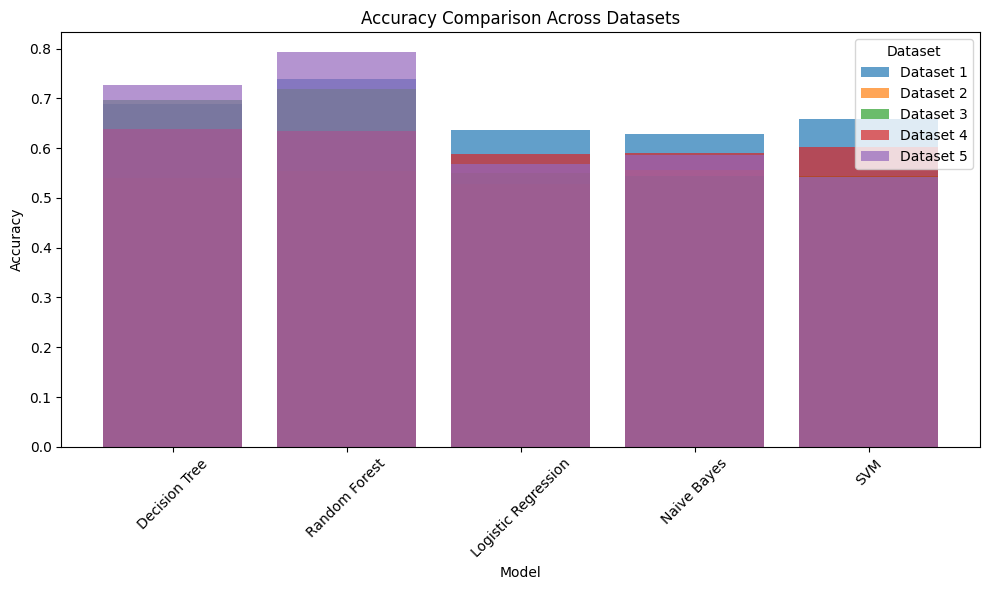

In [87]:
import matplotlib.pyplot as plt

def plot_accuracy_comparison(dfs, dataset_labels):
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        plt.bar(df['Model'], df['Accuracy'], alpha=0.7, label=dataset_labels[i])
    
    plt.title('Accuracy Comparison Across Datasets')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.legend(title='Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

dfs = [df1, df2, df3, df4, df5]
dataset_labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4', 'Dataset 5']

plot_accuracy_comparison(dfs, dataset_labels)

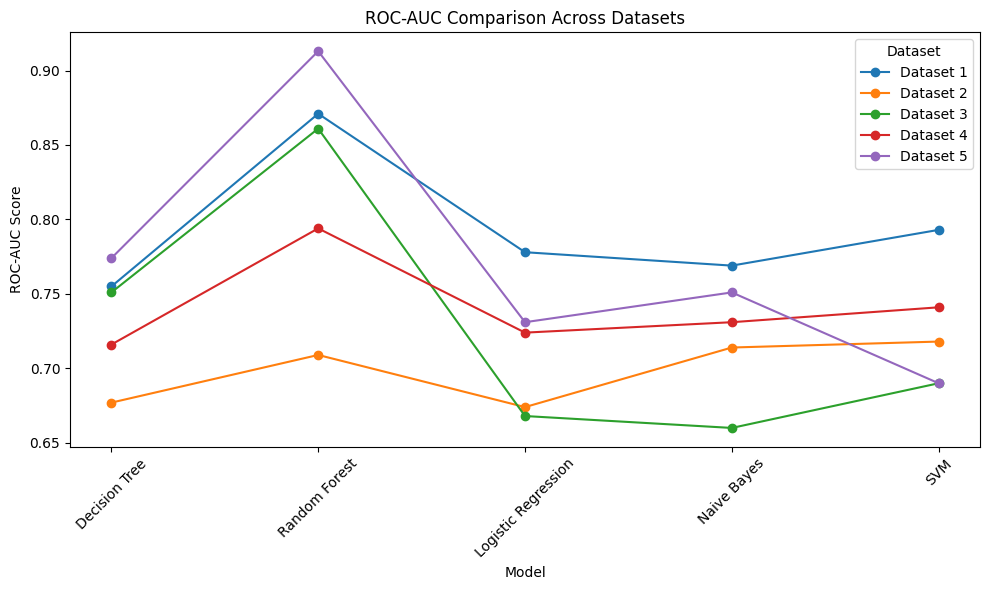

In [88]:
def plot_roc_auc_comparison(dfs, dataset_labels):
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        plt.plot(df['Model'], df['ROC-AUC'], marker='o', label=dataset_labels[i])
    
    plt.title('ROC-AUC Comparison Across Datasets')
    plt.xlabel('Model')
    plt.ylabel('ROC-AUC Score')
    plt.legend(title='Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_roc_auc_comparison(dfs, dataset_labels)


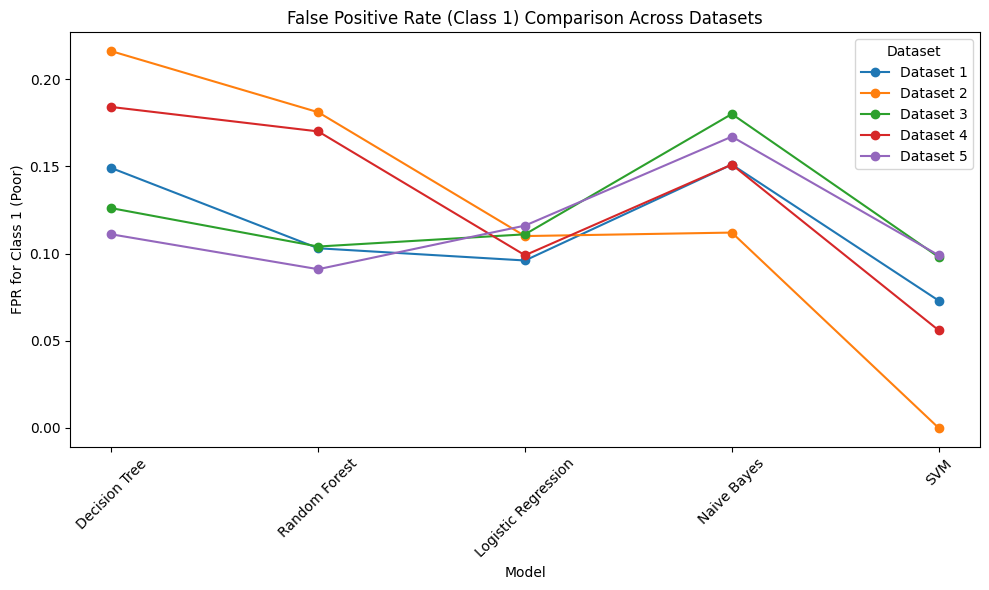

In [89]:
def plot_fpr_class_1_comparison(dfs, dataset_labels):
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        plt.plot(df['Model'], df['FPR_Class_1'], marker='o', label=dataset_labels[i])
    
    plt.title('False Positive Rate (Class 1) Comparison Across Datasets')
    plt.xlabel('Model')
    plt.ylabel('FPR for Class 1 (Poor)')
    plt.legend(title='Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_fpr_class_1_comparison(dfs, dataset_labels)

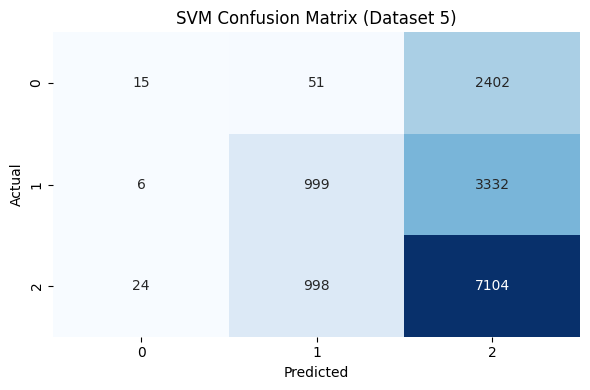

In [91]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred, 'SVM Confusion Matrix (Dataset 5)')
